In [3]:
import sys, platform, os
import numpy as np
import camb
import pandas as pd
import healpy as hp
from camb import model, initialpower
import useful_functions as uf
import pysm3
from fgbuster import (CMB, Dust, Synchrotron, basic_comp_sep,get_observation, get_instrument)
from fgbuster.visualization import corner_norm

In [5]:
seed_test=70
np.random.seed(seed_test)# i set a seed for the generation of the maps and the a_lm. I use a seed for reproducibility.

n_tot=100
nproc=10
n_maps=int((n_tot-n_tot%nproc)/nproc) #so that is divisible
n_channels=2

instrument = get_instrument('LiteBIRD')
sensitivities=instrument["depth_p"]

n_freq=len(sensitivities)
nside=16
n_pix=hp.nside2npix(nside)

/home/amorelli/fgbuster/fgbuster/observation_helpers.py:97: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  return df.dropna(1, 'all')


In [6]:
home_dir="/home/amorelli/QU_foreground_tau/noise_generation/" 
sync_file=home_dir+"d0s0_file.npz"
npzfile = np.load(sync_file)
sync_freq_maps=npzfile['sync_freq_maps']

r=np.ones(1)*0.01
data=uf.generate_cl(n_spectra=1,Nside=512,Nside_red=nside,tau_interval=[0.06,0.06],r_interval=[0.01,0.01], raw=False)

beam_w=2*hp.nside2resol(nside, arcmin=False)

components = [CMB(), Dust(150.), Synchrotron(20.)]


In [7]:
noise_maps=np.ones(shape=(n_freq,n_maps,n_pix,n_channels))
#noise_maps_T=np.ones(shape=(n_freq,n_maps,n_pix))
for i,s in enumerate(sensitivities):
    corr=np.sqrt(2)
    noise=uf.generate_noise_maps(n_maps,n_channels,nside,sensitivity=s*corr)#if i consider half of the execution time the error increases
    #you can prove it using S/N formula
    #noise_T=uf.generate_noise(n_maps,s*corr/np.sqrt(2),nside)
    noise_maps[i]=noise
    #noise_maps_T[i]=noise_T

In [8]:
noise=noise_maps[0]*0.0

maps_per_cl_gen=uf.maps_per_cl(distribution=0)
maps_per_cl=maps_per_cl_gen.compute_maps_per_cl(r,n_train=n_maps,n_train_fix=n_maps)

QU_maps=uf.generate_maps(data=data, r=r,n_train=n_maps,nside=16, map_per_cl=maps_per_cl, noise_maps=noise, beam_w=beam_w, kind_of_map="QU", raw=1, n_channels=2, beam_yes=1 , verbose=0)[0]
#T_maps=uf.generate_maps(data=data, r=r,n_train=n_maps,nside=16, n_train_fix=0, 
                        #beam_w=beam_w, kind_of_map="TT", raw=1 , distribution=0, n_channels=1, 
                        #sensitivity=0,beam_yes=1 , verbose=0)[0]


0


In [20]:
freq_maps=np.ones(shape=(n_channels,n_maps,n_freq,2,n_pix))
#freq_maps=np.ones(shape=(n_maps,n_freq,3,n_pix))
for j in range(n_maps):
    for i in range(n_freq):
        # freq_maps[j,i,0]=noise_maps_T[i,j]+sync_freq_maps[i,0]+T_maps[j,:,0]
        # freq_maps[j,i,1]=noise_maps[i,j]+sync_freq_maps[i,1]+QU_maps[j,:,0]
        # freq_maps[j,i,2]=noise_maps[i,j]+sync_freq_maps[i,2]+QU_maps[j,:,1]
        for k in range(n_channels):
            freq_maps[k,j,i,0]=noise_maps[i,j,:,k]+sync_freq_maps[i,1]+QU_maps[j,:,k*n_channels]
            freq_maps[k,j,i,1]=noise_maps[i,j,:,k]+sync_freq_maps[i,2]+QU_maps[j,:,k*n_channels+1]

result = np.ones(shape=(n_channels,n_maps,2,n_pix))
#result = np.ones(shape=(n_maps,3,n_pix))
for i in range(n_maps):
    for k in range(n_channels):
        compsep=basic_comp_sep(components, instrument, freq_maps[k,i])
        result[k,i]=compsep.s[0]
        for j in range(2):
            result[k,i,j,:]=result[k,i,j,:]-QU_maps[i,:,j+k*n_channels]

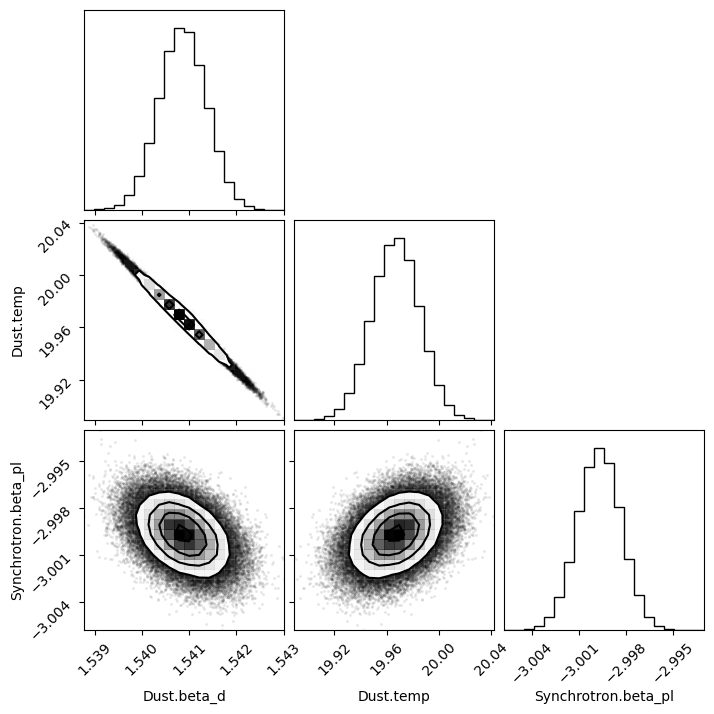

In [21]:
corner_norm(compsep.x, compsep.Sigma, labels=compsep.params)

In [ ]:
#comparing Cl+Nl with Cl+Nl+Dl+Sl